<a href="https://colab.research.google.com/github/shihanxie/Econ475/blob/main/LiqourSale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Putting it together
We use liquor sale as and example to model and forecast a variable with a quardratic trend, seasonal dummies, and a cyclical component

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

### Import and plot data
- The sample is monthly and covers the period from 1968M1 to 1995M12
- We first use the sample up to 1993M12 (do not include observations from 1995)

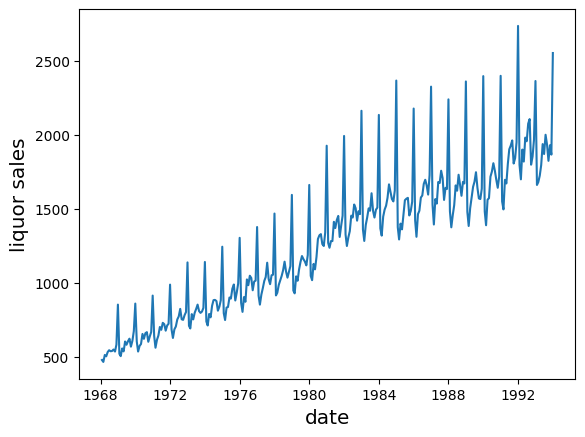

In [2]:
liquor = pd.read_csv('https://raw.githubusercontent.com/shihanxie/Econ475/main/data/DataLiquor.csv')
liquor.index = pd.date_range(start='1968-01-01', periods= liquor.shape[0], freq='M')

# Define the start and end date of the sample we use
start = '1968-01-01'
end = '1994-01-01'

plt.plot(liquor['liquorsales'][start:end])
# Plots the sample from 'start' - 'end' dates as defined ('end' date exclusive)
ax = plt.gca()
ax.set_ylabel('liquor sales', fontsize = 'x-large')
ax.set_xlabel('date', fontsize = 'x-large')
plt.show()

Generate and plot ```log(liquor sale)```

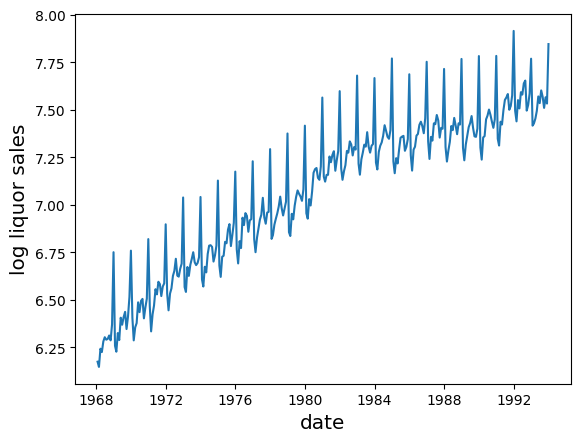

In [3]:
liquor['logliquor'] = np.log(liquor['liquorsales'])

plt.plot(liquor['logliquor'][start:end])
ax = plt.gca()
ax.set_ylabel('log liquor sales', fontsize = 'x-large')
ax.set_xlabel('date', fontsize = 'x-large')
plt.show()

## Quadratic trend model

In [4]:
# Generate constant and time variables
liquor['constant'] = 1
# np.arange(T) generates array from 0 to T-1
# liquor.shape[0] refers to the number of rows in DataFrame liquor
# liquor.shape[0] also represents the numebr of observations T
liquor['time'] = np.arange(liquor.shape[0])+1
liquor['time2'] = liquor['time']**2

# Quadratic trend model
# Define the dependent variable as Y, independent variables as x_quadratic
# When we use the same dependent variable Y in our subsequent code, we do not need to define it again
Y = liquor['logliquor'][start:end]
X_quadratic = liquor[['constant','time','time2']][start:end]

# sm.OLS(Y,X_quadratic) regresses Y on regressors in X_quadratic
result_quadratic = sm.OLS(Y,X_quadratic, missing='drop').fit()
print(result_quadratic.summary())

                            OLS Regression Results                            
Dep. Variable:              logliquor   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     1457.
Date:                Thu, 04 Apr 2024   Prob (F-statistic):          4.55e-158
Time:                        15:50:32   Log-Likelihood:                 207.22
No. Observations:                 312   AIC:                            -408.4
Df Residuals:                     309   BIC:                            -397.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant       6.2437      0.021    291.871      0.0

In [5]:
np.sqrt(result_quadratic.mse_resid)

0.1251459740259134

###Residual Plot

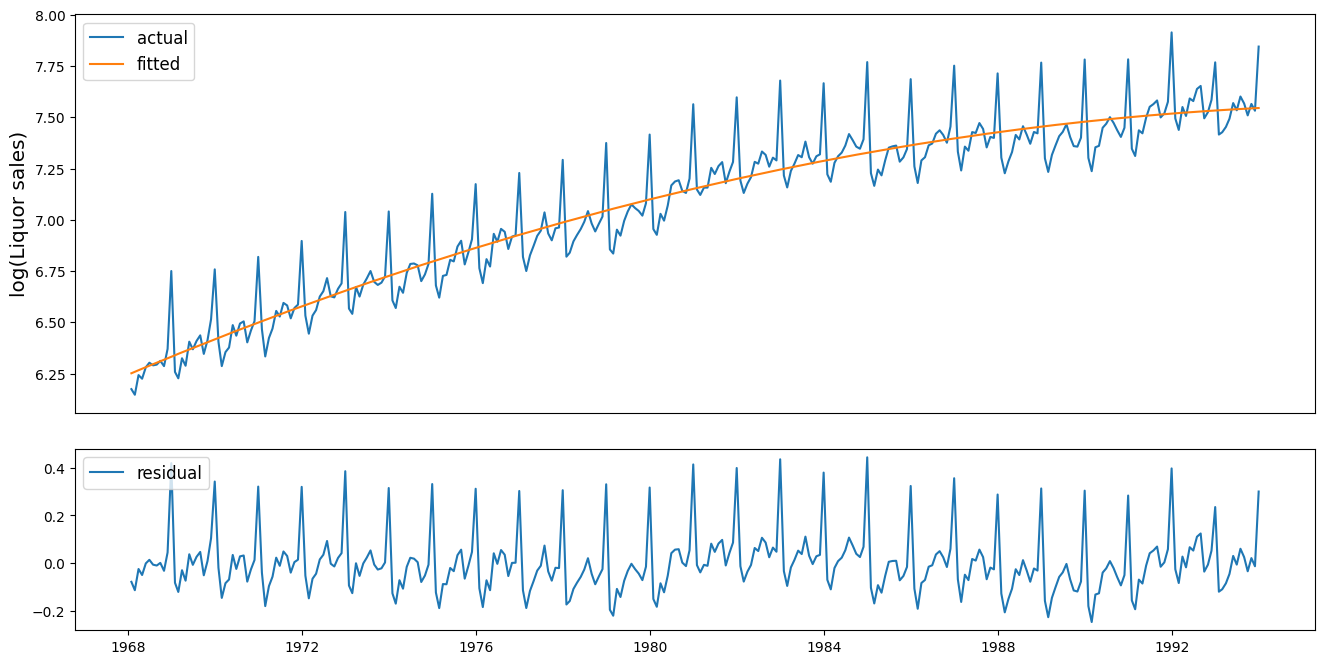

In [6]:
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs[:2])
ax2 = fig.add_subplot(gs[2], sharex=ax1)

# Plots dependent variable Y and fitted values in the upper panel
ax1.plot(Y, label = 'actual')
ax1.plot(result_quadratic.fittedvalues, label = 'fitted')

# Plots residuals in the lower panel
ax2.plot(result_quadratic.resid, '-',label='residual')

ax1.tick_params(bottom=False, labelbottom=False, left=True, labelleft=True)
ax1.set_ylabel('log(Liquor sales)', fontsize = 'x-large')

ax1.legend(loc='upper left', fontsize = 'large')
ax2.legend(loc='upper left', fontsize = 'large')
plt.show()

If you only want to plot the residuals:

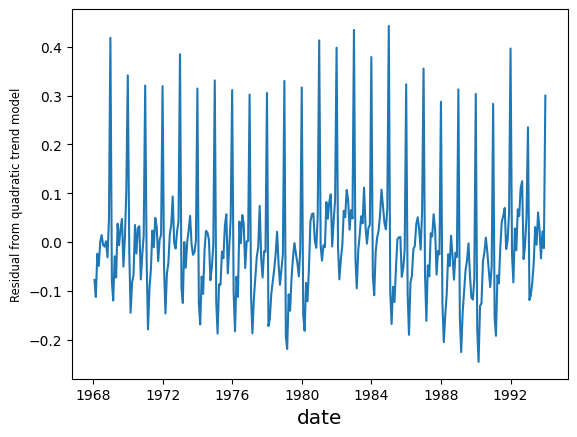

In [7]:
plt.plot(result_quadratic.resid)
ax = plt.gca()
ax.set_ylabel('Residual from quadratic trend model', fontsize = 'small')
ax.set_xlabel('date', fontsize = 'x-large')
plt.show()

### Plot the correlogram of the residuals

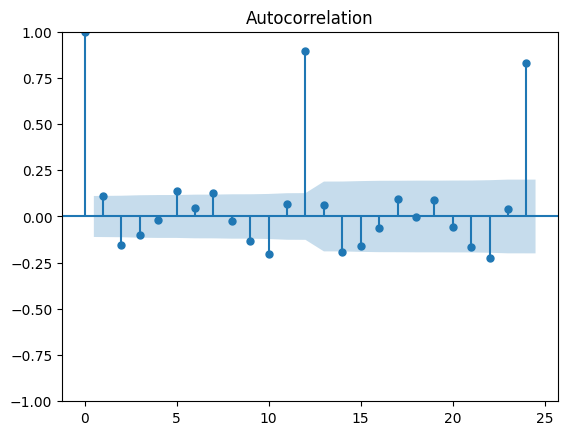

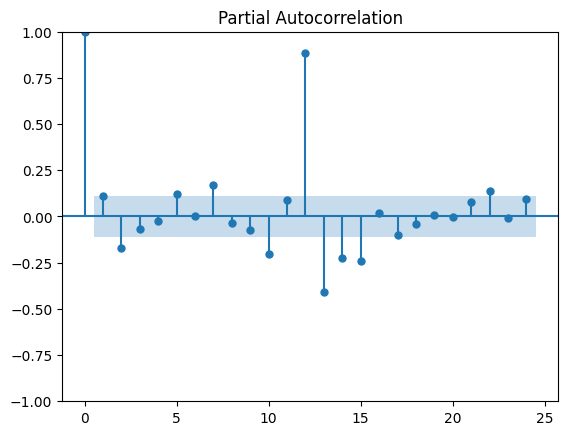

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(result_quadratic.resid, lags=24)
plot_pacf(result_quadratic.resid, lags=24)
plt.show()

## Trend and Seasonal Model

In [9]:
# Generate dummy variables for every month
liquor['month'] = pd.DatetimeIndex(liquor.index).month
dummy = pd.get_dummies(liquor['month'], prefix='m', dtype = int)

# Merge the dummies variables with liquor sales data and obtain a new DataFrame named "df"
df = pd.concat([liquor,dummy], axis=1)

In [10]:
# Define the new independent variables for this regression with both trend and seasonal components
Y = df['logliquor'][start:end]
X_season = df[['time', 'time2', 'm_1','m_2','m_3','m_4','m_5','m_6','m_7','m_8','m_9','m_10','m_11','m_12']][start:end]

result_season = sm.OLS(Y, X_season, missing='drop').fit()
print(result_season.summary())

                            OLS Regression Results                            
Dep. Variable:              logliquor   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     1945.
Date:                Thu, 04 Apr 2024   Prob (F-statistic):          2.43e-279
Time:                        15:50:56   Log-Likelihood:                 536.03
No. Observations:                 312   AIC:                            -1044.
Df Residuals:                     298   BIC:                            -991.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
time           0.0074      0.000     66.266      0.0

In [11]:
np.sqrt(result_season.mse_resid)

0.044422044724929007

Breusch-Godfrey test for serial correlations in the residuals

In [12]:
from statsmodels.stats import diagnostic
bgtest = diagnostic.acorr_breusch_godfrey(result_season, nlags = 12)
print('Breusch Godfrey test LM statistic: ', bgtest[0])
print('Breusch Godfrey test LM p-value: ', bgtest[1])

Breusch Godfrey test LM statistic:  200.52833443314006
Breusch Godfrey test LM p-value:  2.537201928805606e-36


### Residual plot

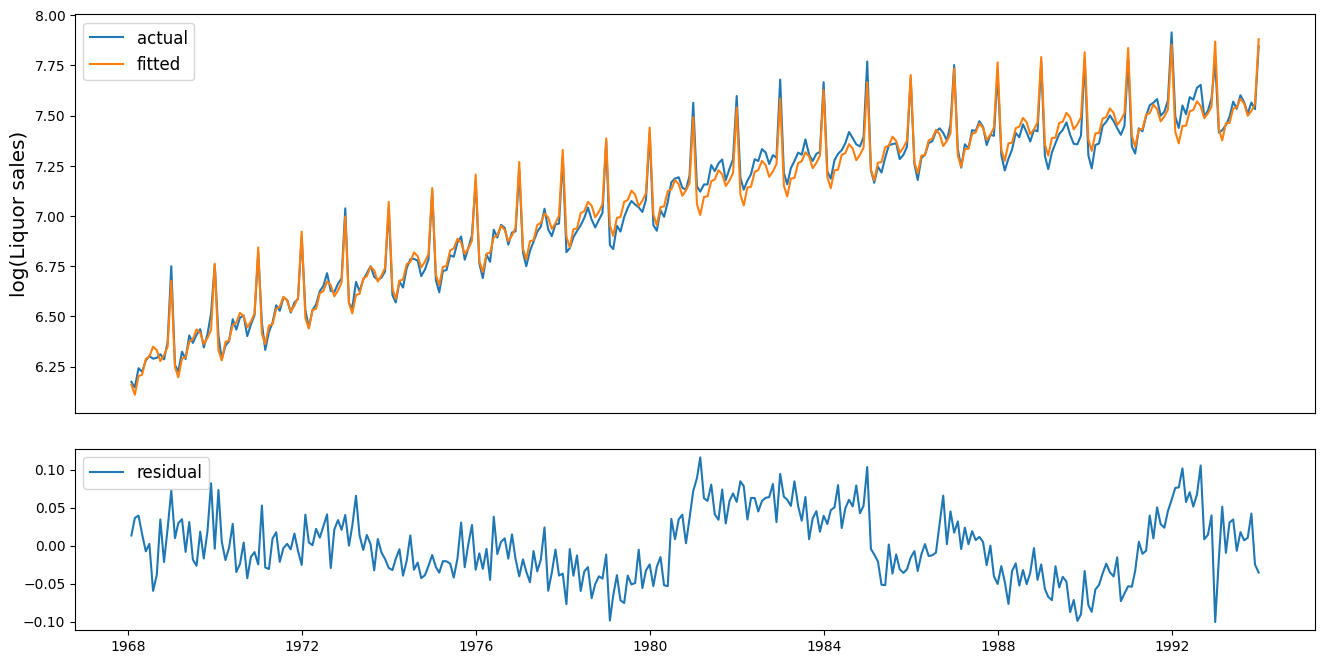

In [13]:
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs[:2])
ax2 = fig.add_subplot(gs[2], sharex=ax1)

ax1.plot(Y, label = 'actual')
ax1.plot(result_season.fittedvalues, label = 'fitted')

ax2.plot(result_season.resid, '-',label='residual')

ax1.tick_params(bottom=False, labelbottom=False, left=True, labelleft=True)
ax1.set_ylabel('log(Liquor sales)', fontsize = 'x-large')

ax1.legend(loc='upper left', fontsize = 'large')
ax2.legend(loc='upper left', fontsize = 'large')
plt.show()

Exercise: plot the residuals from the seasonal regression and label it properly



### Plot correlogram of the residuals

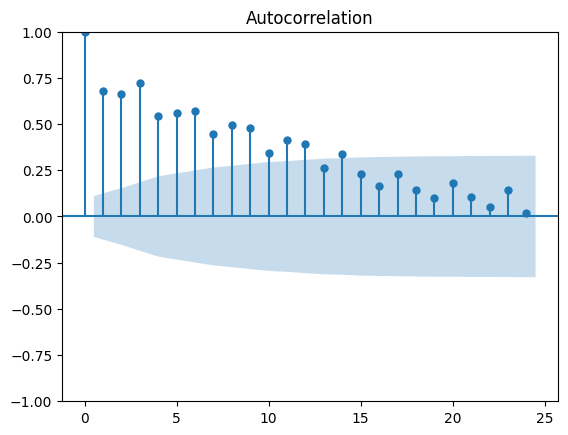

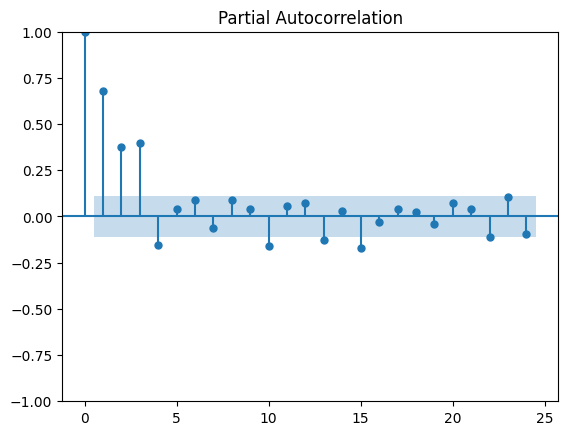

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(result_season.resid, lags=24)
plot_pacf(result_season.resid, lags=24)
plt.show()

## Model with quadratic trend, a full set of seasonal dummies and AR(3)

In [15]:
# Include time, time**2, and seasonal dummies as exogenous variables
# trend='n': exclude constant term to avoid dummy trap
# Define X1 as the set of exogenous regressors
X1 = df[['time', 'time2', 'm_1','m_2','m_3','m_4','m_5','m_6','m_7','m_8','m_9','m_10','m_11','m_12']][start:end]
result_arma = ARIMA(Y, order=(3,0,0), trend='n', exog=X1).fit()
print(result_arma.summary())

                               SARIMAX Results                                
Dep. Variable:              logliquor   No. Observations:                  312
Model:                 ARIMA(3, 0, 0)   Log Likelihood                 683.015
Date:                Thu, 04 Apr 2024   AIC                          -1330.030
Time:                        15:51:19   BIC                          -1262.656
Sample:                    01-31-1968   HQIC                         -1303.103
                         - 12-31-1993                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
time           0.0074      0.001     13.459      0.000       0.006       0.009
time2      -1.058e-05   1.59e-06     -6.659      0.000   -1.37e-05   -7.46e-06
m_1            6.1531      0.040    153.444      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


###Durbin-Watson test and Breusch-Godfrey test for serial correlations in the residuals

In [16]:
bgtest = diagnostic.acorr_breusch_godfrey(result_arma, nlags = 12)
print('Breusch Godfrey test LM statistic: ', bgtest[0])
print('Breusch Godfrey test LM p-value: ', bgtest[1])

Breusch Godfrey test LM statistic:  28.946196569309734
Breusch Godfrey test LM p-value:  0.004013104051841441


In [17]:
from statsmodels.stats import stattools as st
st.durbin_watson(result_arma.resid)

1.8578146602572374

### Residual plot

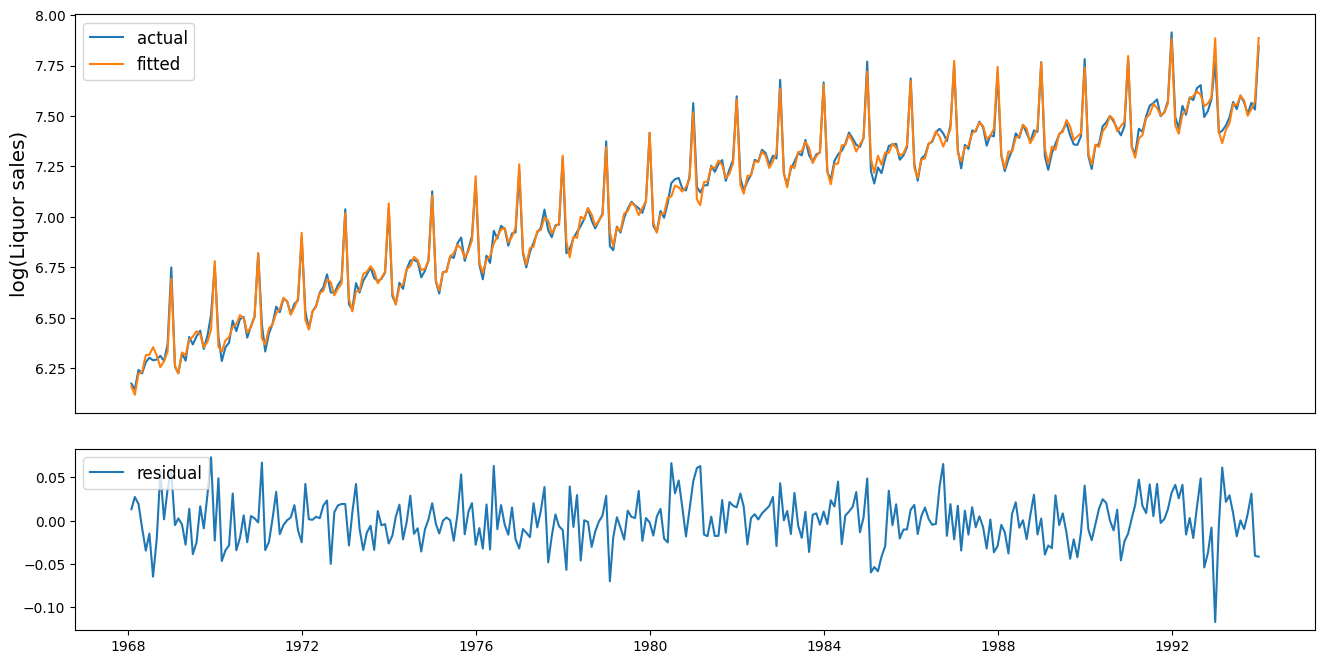

In [18]:
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs[:2])
ax2 = fig.add_subplot(gs[2], sharex=ax1)

ax1.plot(Y, label = 'actual')
ax1.plot(result_arma.fittedvalues, label = 'fitted')

ax2.plot(result_arma.resid, '-',label='residual')

ax1.tick_params(bottom=False, labelbottom=False, left=True, labelleft=True)
ax1.set_ylabel('log(Liquor sales)', fontsize = 'x-large')

ax1.legend(loc='upper left', fontsize = 'large')
ax2.legend(loc='upper left', fontsize = 'large')
plt.show()

###Plot correlogram of the residuals

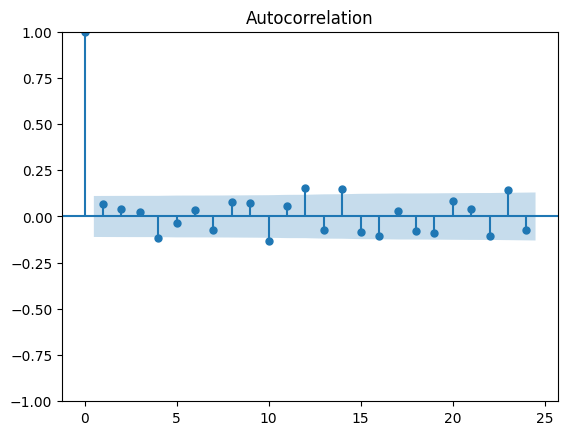

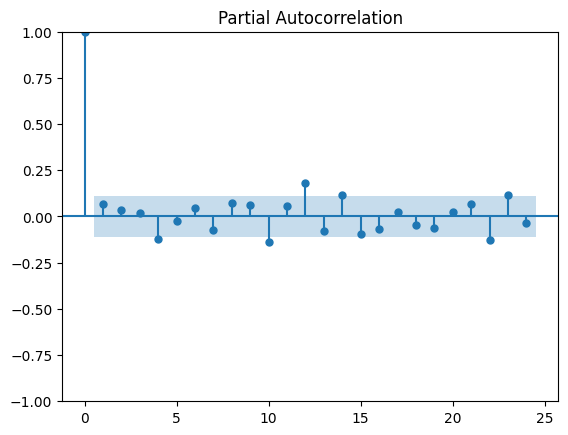

In [19]:
plot_acf(result_arma.resid, lags=24)
plot_pacf(result_arma.resid, lags=24)
plt.show()

### Forecast using the estimated model with quadratic trend, a full set of seasonal dummies and AR(3)

First, forecast ```log(liquor sale)``` for 1994M1 - 1995M12 and compare it with the actual data

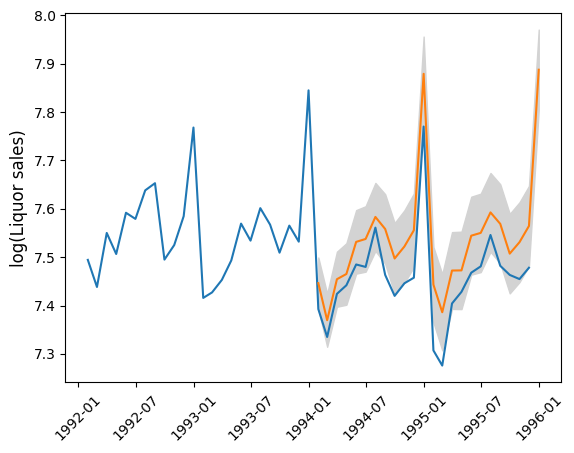

In [20]:
# Define the start and end(exclusive) date of our forecasting period
forecast_start = '1994-01-01'
forecast_end = '1996-01-01'

# Assign values to the exogenous regressors for our forecasting period
X_exog = df[['time', 'time2', 'm_1','m_2','m_3','m_4','m_5','m_6','m_7','m_8','m_9','m_10','m_11','m_12']][forecast_start:forecast_end]
forecast = result_arma.get_forecast(24, exog=X_exog)
mean_forecast = forecast.predicted_mean
confidence_interval = forecast.conf_int()

plt.plot(df['logliquor']['1992-01-01':'1995-12-01'])
plt.plot(df.index[-24:], mean_forecast.values)
ax = plt.gca()
ax.tick_params(axis = 'x', rotation = 45)
ax.set_ylabel('log(Liquor sales)', fontsize = 'large')

# Shade confidence interval
plt.fill_between(df.index[-24:], confidence_interval['lower logliquor'], confidence_interval['upper logliquor'], color='lightgrey')
plt.show()

Forecast the **level** of liquor sale until 1998M12
- We need to construct the exogenous variables for the out-of-sample period

In [21]:
exogdate = pd.date_range(start=forecast_start, periods= 72, freq='M').to_frame(index=False, name='date')
month = pd.DatetimeIndex(exogdate['date']).month
exog_var = pd.get_dummies(month, prefix='m', dtype = int)
exog_var['time'] = exog_var.index - 24 + df.shape[0] + 1
exog_var['time2'] = exog_var['time']**2
X_exog_forecast = exog_var[['time', 'time2', 'm_1','m_2','m_3','m_4','m_5','m_6','m_7','m_8','m_9','m_10','m_11','m_12']]

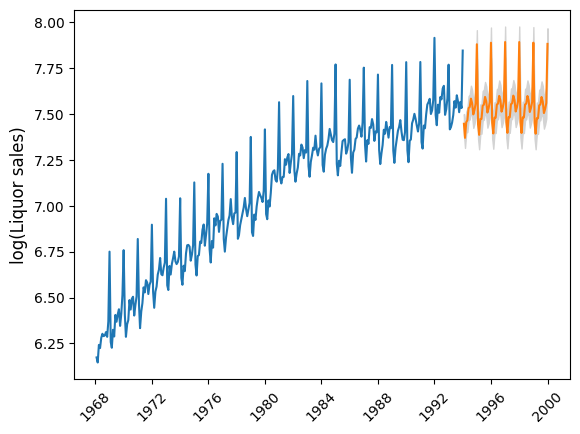

In [22]:
forecast = result_arma.get_forecast(72, exog = X_exog_forecast)
mean_forecast = forecast.predicted_mean
confidence_interval = forecast.conf_int()

plt.plot(Y)
plt.plot(exogdate, mean_forecast.values)
plt.fill_between(exogdate['date'], confidence_interval['lower logliquor'], confidence_interval['upper logliquor'], color='lightgrey')

ax = plt.gca()
ax.tick_params(axis = 'x', rotation = 45)
ax.set_ylabel('log(Liquor sales)', fontsize = 'large')

plt.show()

Plot the level of liquor sale and our forecast

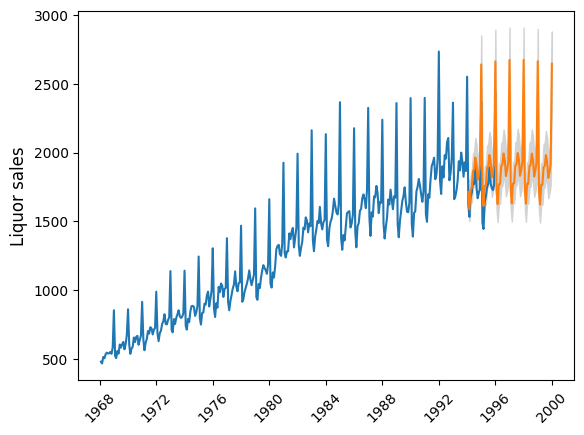

In [23]:
liquor_mean = np.exp(mean_forecast)
liquor_lower = np.exp(confidence_interval['lower logliquor'])
liquor_upper = np.exp(confidence_interval['upper logliquor'])

plt.plot(df['liquorsales'])
plt.plot(exogdate, liquor_mean)
plt.fill_between(exogdate['date'], liquor_lower, liquor_upper, color='lightgrey')

ax = plt.gca()
ax.tick_params(axis = 'x', rotation = 45)
ax.set_ylabel('Liquor sales', fontsize = 'large')

plt.show()

### Recursive estimation
First, construct lagged values of ```logliquor```

In [24]:
df['L1_logliquor'] = df['logliquor'].shift(1)
df['L2_logliquor'] = df['logliquor'].shift(2)
df['L3_logliquor'] = df['logliquor'].shift(3)

In [25]:
exog = df[['time', 'time2', 'm_1','m_2','m_3','m_4','m_5','m_6','m_7','m_8','m_9','m_10','m_11','m_12', 'L1_logliquor', 'L2_logliquor', 'L3_logliquor']]
model = sm.RecursiveLS(df['logliquor'][3:], exog[3:])
result_rec = model.fit()
print(result_rec.summary())

                           Statespace Model Results                           
Dep. Variable:              logliquor   No. Observations:                  333
Model:                    RecursiveLS   Log Likelihood                 629.695
Date:                Thu, 04 Apr 2024   R-squared:                       0.995
Time:                        15:52:08   AIC                          -1225.391
Sample:                    04-30-1968   BIC                          -1160.652
                         - 12-31-1995   HQIC                         -1199.576
Covariance Type:            nonrobust   Scale                            0.001
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
time             0.0009      0.000      2.865      0.004       0.000       0.001
time2        -1.456e-06    4.8e-07     -3.037      0.002    -2.4e-06   -5.16e-07
m_1              0.5014      0.241      2.08

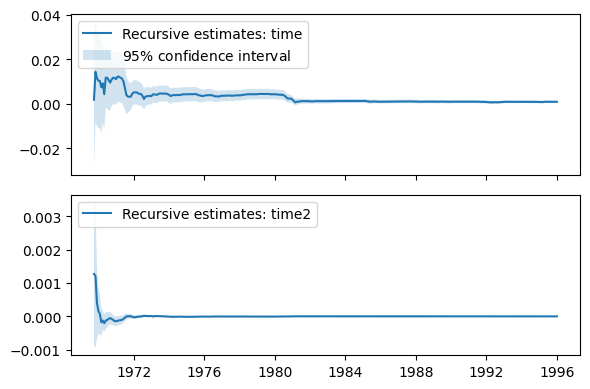

In [26]:
# plot recursive parameter estimates for trend component
result_rec.plot_recursive_coefficient(range(0,2), figsize=(6,4));

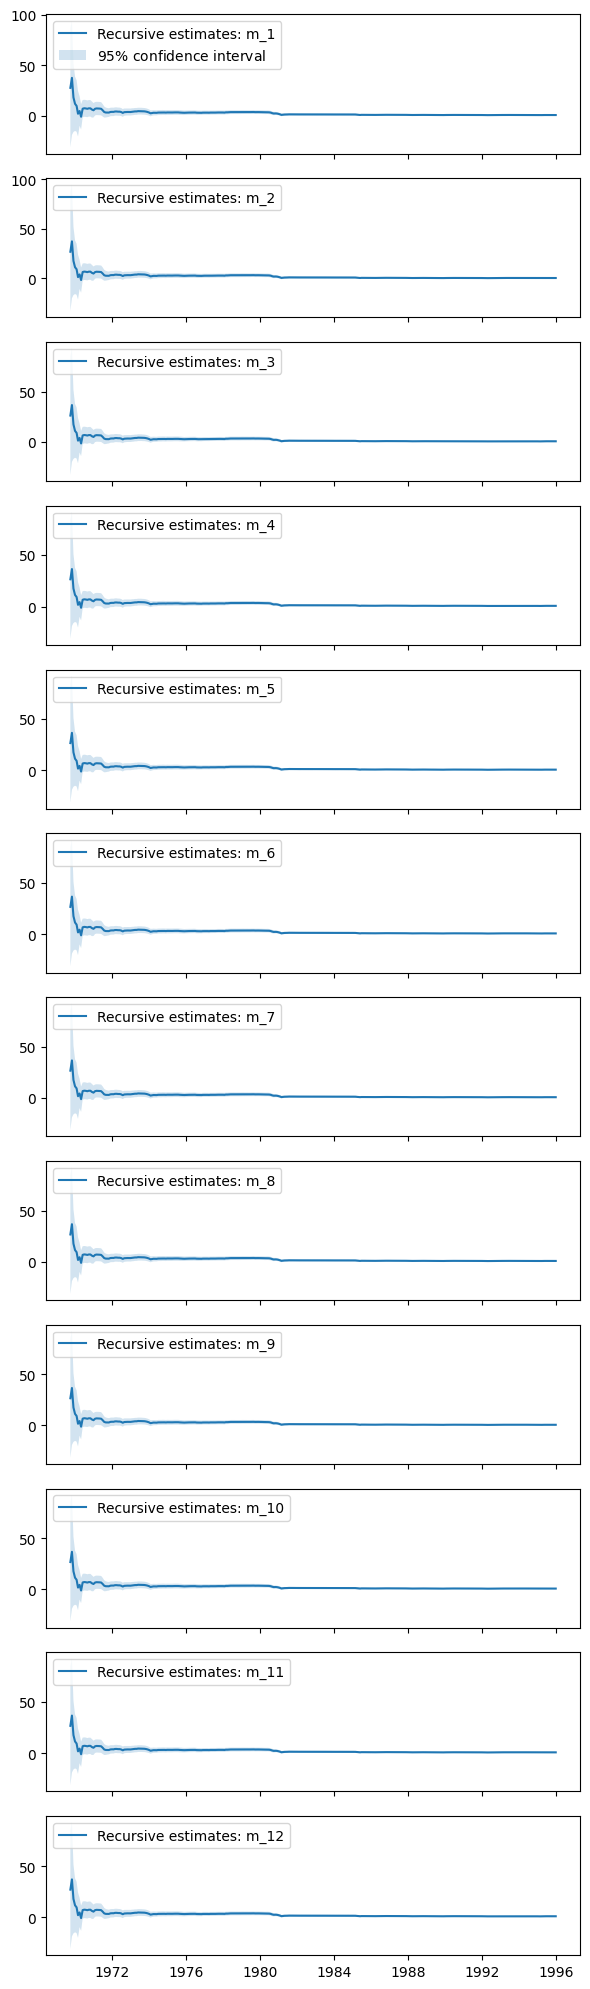

In [27]:
# plot recursive parameter estimates for seasonal component
result_rec.plot_recursive_coefficient(range(2,14), figsize=(6,20));

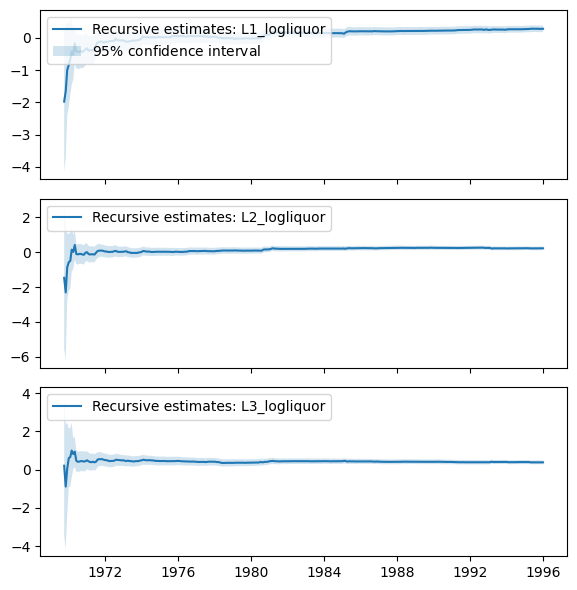

In [28]:
# plot recursive parameter estimates for AR coefficients
result_rec.plot_recursive_coefficient(range(14,17), figsize=(6,6));

Cumsum plot

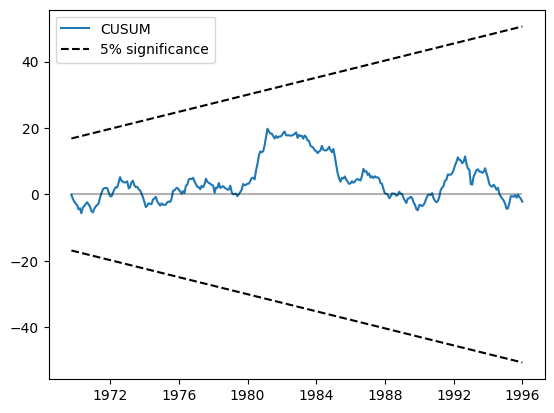

In [29]:
fig = result_rec.plot_cusum()

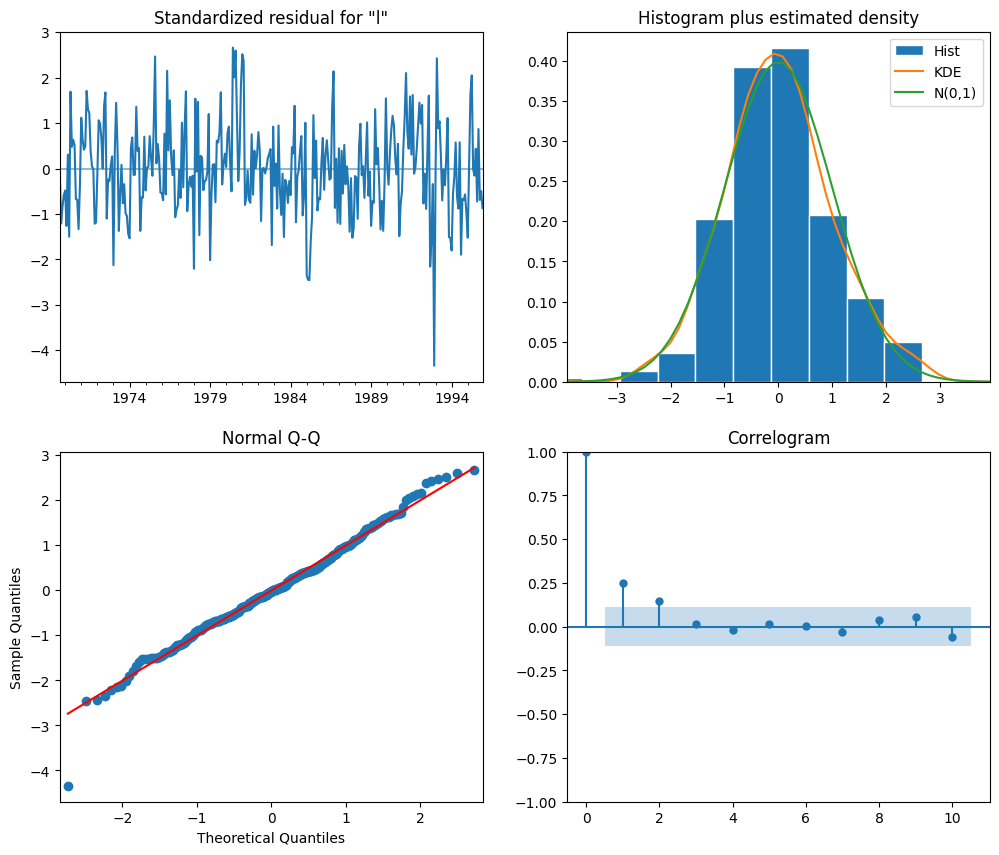

In [30]:
fig = result_rec.plot_diagnostics(figsize=(12,10))